In [291]:
%matplotlib inline

from scipy import stats
from decimal import Decimal
import statsmodels.formula.api as sm
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [361]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import gridspec


params = {
   'axes.labelsize': 18,
   'font.size': 24,
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.titlesize':18,
   'text.usetex': True,
   'figure.figsize': [8, 8],
   'font.family':'serif',
   'font.serif':'Computer Modern Roman' 
   }
mpl.rcParams.update(params)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{bm}']

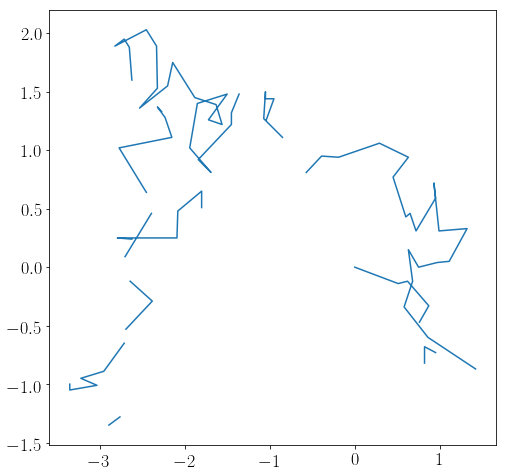

In [362]:
path_data_ori = np.genfromtxt('extracted_data.txt',delimiter=',')
path_initial = [path_data_ori[0,:],]*len(path_data_ori[:,0])
path_data_centered = path_data_ori - path_initial

particle_num = 36
xpos = 2*particle_num 
ypos = 2*particle_num+1

plt.plot(path_data_centered[:,xpos],path_data_centered[:,ypos])

In [363]:
max_2 = 100
max_grad = 4

def dist_array(data):
    
    return_array = []
    
    for part in range(0,int(len(data[0,:])/2)):
        xpos = 2*part
        ypos = 2*part+1
        
        x,y = path_data_centered[:,xpos],path_data_centered[:,ypos]
                
        dist_2_array = x**2+y**2
        
        if max(dist_2_array) < max_2 and max(np.gradient(np.sqrt(dist_2_array))) < max_grad:
            return_array.append(dist_2_array)
        
    return return_array
        
     
r2_array = dist_array(path_data_centered)
expect_r2_array = np.nanmean(r2_array,axis=0)
time_array = np.linspace(0,10,101)

In [364]:
import pandas as pd
# Conducting weighted linear least squares fit
# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': time_array,
    'y': expect_r2_array
})

wls_fit = sm.wls('y ~ x -1', data=ws).fit()

In [365]:
wls_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.877e+04
Date:                Tue, 13 Mar 2018   Prob (F-statistic):          7.56e-125
Time:                        14:37:08   Log-Likelihood:                -69.817
No. Observations:                 101   AIC:                             141.6
Df Residuals:                     100   BIC:                             144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.4156      0.008    169.620      0.000       1.399       1.432
==============================================================================
Omnibus:                        7.737   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               11.960
Skew:                          -0.276   Prob(JB):                      0.00253
Kurtosis:                       4.593   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [366]:
slope = wls_fit.params[0]
slope_uncer = np.sqrt(wls_fit.cov_params()['x'][0])
print('Self Diffusion, DM: %.2E +- %.0E m^2/s'%(Decimal(slope/4*(10**(-6))**2),Decimal(slope_uncer/4*(10**(-6))**2)))

Self Diffusion, DM: 3.54E-13 +- 2E-15 m^2/s


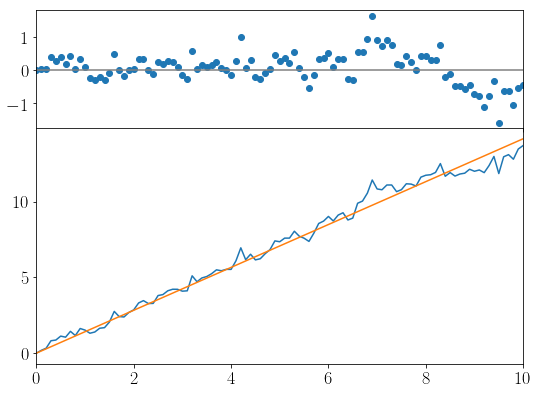

In [367]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2],hspace=0.0) 
ax0 = plt.subplot(gs[0])
ax0.plot([0,10],[0,0],color='grey')
ax0.scatter(time_array,expect_r2_array-slope*time_array)
ax0.set_xlim([0,10])
ax0.set_xticklabels([])

ax1 = plt.subplot(gs[1])
ax1.plot(time_array,expect_r2_array)
ax1.plot(time_array,slope*time_array)
ax1.set_xlim([0,10])

plt.tight_layout()

In [368]:
t = 80*10**(-6)
u_t = 10*10**(-6)
a = 0.63*10**(-6)
u_a = 0.05*10**(-6)
delta = slope*(10**(-6))**2
u_delta = slope_uncer*(10**(-6))**2

D = delta/4*(1-9*a/(4*t))**(-1)

#u_D calculation
a_comp = u_a*(-9)/(4*t)*(1-(9*a)/(4*t))**(-2)*delta
t_comp = u_t*(-9*a)/(4*t**2)*(1-(9*a)/(4*t))**(-2)*delta
delta_comp = u_delta*(1-(9*a)/(4*t))**(-1)

u_D = (a_comp**2+t_comp**2+delta_comp**2)**(1/2)

print('The diffusion coefficient (D not DM): %.2E +- %.0E'%(Decimal(D),Decimal(u_D)))

The diffusion coefficient (D not DM): 3.60E-13 +- 9E-15


In [369]:
T_array = np.array([10,15,20,25,30]) + 273.15
eta_array = np.array([1308,1139,1003,891,798])*10**(-6)

T = 20+273.15
u_T = 1

In [370]:
eta_func = interp1d(T_array,eta_array)

eta = float(eta_func(T))
u_eta = eta - float(eta_func(T+u_T))
print('Viscocity: %0.2E +- %.0E    m^2/s' % (Decimal(eta),Decimal(u_eta)))

Viscocity: 1.00E-03 +- 2E-05    m^2/s


In [371]:
kb = 6*np.pi*eta*a/T*D

# u_kb calculation
T_comp = u_T*6*np.pi*eta*a*D/(T**2)
eta_comp = u_eta*6*np.pi*a*D/T
a_comp = u_a*6*np.pi*eta*D/T
D_comp = u_D*6*np.pi*eta*a/T

u_kb = np.sqrt(T_comp**2+eta_comp**2+a_comp**2+D_comp**2)

print('Boltzmann\'s constant: %.2E +- %.0E     m^2 kg /s^2 K'%(Decimal(kb), Decimal(u_kb)))

Boltzmann's constant: 1.46E-23 +- 1E-24     m^2 kg /s^2 K


In [372]:
R = 8.314

Na = R*T/(6*np.pi*eta*a*D)

# u_Na calculation
T_comp = u_T*R/(6*np.pi*eta*D*a)
eta_comp = u_eta*R*T/(6*np.pi*eta**(2)*D*a)
a_comp = u_a*R*T/(6*np.pi*eta*D*a**(2))
D_comp = u_D*R*T/(6*np.pi*eta*D**(2)*a)

u_Na = np.sqrt(T_comp**2+eta_comp**2+a_comp**2+D_comp**2)

print('Avogrado\'s number: %.2E +- %.0E    atoms/mole'%(Decimal(Na),Decimal(u_Na)))

Avogrado's number: 5.68E+23 +- 5E+22    atoms/mole


In [438]:
cutoff = 1

def prob_array(data, times):
    
    x_array = []
    y_array = []
    
    times= times[cutoff:]
    
    for part in range(0,int(len(data[0,:])/2)):
        xpos = 2*part
        ypos = 2*part+1
        
        x,y = path_data_centered[:,xpos],path_data_centered[:,ypos]
        
        x = x[cutoff:]
        y = y[cutoff:]
        
        dist_2_array = x**2+y**2

        xs = x*2/times
        ys = y*2/times
        
        #if max(dist_2_array) < max_2 and max(np.gradient(np.sqrt(dist_2_array))) < max_grad and len(xs[np.where(np.abs(xs) == 0.0)]) == 0 and len(ys[np.where(np.abs(ys) == 0.0)]) == 0:
        x_array.extend(xs)
        y_array.extend(ys)
        
    return x_array, y_array

x_list, y_list = prob_array(path_data_centered,time_array)
x_list = np.array(x_list)
y_list = np.array(y_list)

In [439]:
x_list = x_list[~np.isnan(x_list)]
y_list = y_list[~np.isnan(y_list)]

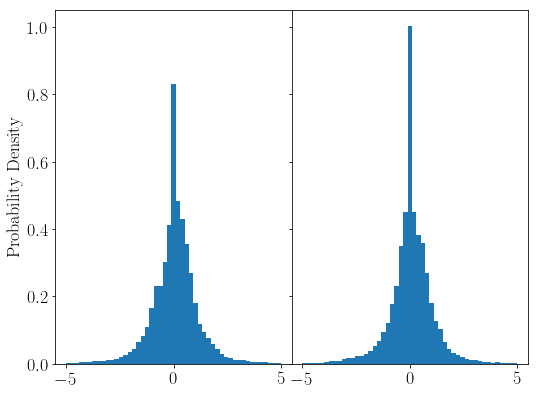

In [446]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, height_ratios=[1],wspace=0.0) 
ax0 = plt.subplot(gs[0])
ax0.hist(x_list,bins=np.linspace(-5,5,50),normed=True)
ax0.set_ylim(0,1.05)

ax1 = plt.subplot(gs[1])
ax1.hist(y_list,bins=np.linspace(-5,5,50),normed=True)
ax0.set_ylabel(r'Probability Density')
ax1.set_yticklabels([])
ax1.set_ylim(0,1.05)

plt.tight_layout()